In [19]:
import tensorflow as tf
import tensorflow_probability as tfp
import seaborn as sns
import arviz as az

## Basics

In [11]:
tfd = tfp.distributions
tfb = tfp.bijectors

"""
* batch_shape : num of probabilistic distributions = batch_size
* event_shape : dimension of probabilistic variables
* sample_shape : num of samples
"""
#2 different gaussian distributions
normal = tfd.Normal(loc=[-1,1],scale=[1,1.5])
print(normal)
print("Shape of sampled tensor:",normal.sample(10).shape) #sample : 10, batch:2,event:[]

#2 dimensional gaussian distribution
mvn = tfd.MultivariateNormalDiag(loc=[0,0],scale_diag=[1,1])
print("Batch_shape:",mvn.batch_shape) #0
print("Event_shape:",mvn.event_shape) #2

#2 independet gaussian distributions
normals = tfd.Normal(loc=[-1,1],scale=1)
print("Batch_shape:",normals.batch_shape) #2
print("Event_shape:",normals.event_shape) #0

print(mvn.sample().shape)#2
print(normals.sample().shape)#2

#logarithmical probability
print(mvn.log_prob(mvn.sample())) #1 output : 1 probabilistic distribution
print(normals.log_prob(normals.sample())) #2 outputs : 2 independent distributions

"""
tfp.distributions.Independent : independent samples from different distributions
- batch_shape -> event_shape
- retinterpreted_batch_ndims : which dimension of batch_shape is converted to event_dimension

tfp.distributions.Sample : independent smaples from the same distribution
- for event_shape : samples_shape -> event_shape
"""
#2 independet gaussian distributions
normals = tfd.Normal(loc=[-1,1],scale=1)
print("Batch_shape:",normals.batch_shape) #2
print("Event_shape:",normals.event_shape) #0
#tfd.Independent
normals_ind = tfd.Independent(normals,reinterpreted_batch_ndims=1)
print("Batch_shape:",normals.batch_shape) #0
print("Event_shape:",normals.event_shape) #2

s=normals.sample()
print("normals sum=",tf.reduce_sum(normals.log_prob(s))) #reduce_sum(input,axis) : sum along axis
print("normals_ind = ",normals_ind.log_prob(s))

#tfd.Sample
bernoulli = tfd.Bernoulli(probs=0.5)
#handle multiple samples at once
bernoulli_samples = tfd.Sample(bernoulli,sample_shape=10)
print(bernoulli_samples) #event_shape = 10
s=bernoulli_samples.sample()
print("shape of single samples:",s.shape)
print(bernoulli_samples.log_prob(s))

tfp.distributions.Normal("Normal", batch_shape=[2], event_shape=[], dtype=float32)
Shape of sampled tensor: (10, 2)
Batch_shape: ()
Event_shape: (2,)
Batch_shape: (2,)
Event_shape: ()
(2,)
(2,)
tf.Tensor(-2.5559235, shape=(), dtype=float32)
tf.Tensor([-0.9375055 -2.5107312], shape=(2,), dtype=float32)
Batch_shape: (2,)
Event_shape: ()
Batch_shape: (2,)
Event_shape: ()
normals sum= tf.Tensor(-3.2506795, shape=(), dtype=float32)
normals_ind =  tf.Tensor(-3.2506795, shape=(), dtype=float32)
tfp.distributions.Sample("SampleBernoulli", batch_shape=[], event_shape=[10], dtype=int32)
shape of single samples: (10,)
tf.Tensor(-6.931472, shape=(), dtype=float32)


## modeling&inference : coin toss

- cf

  - "yield" : a powerful feature in Python that provides a flexible and efficient way to work with sequences and iterators, particularly when dealing with large data sets, complex processing pipelines, or asynchronous programming.

In [18]:
#setting
N = 10 #total trials
x = 6 #success


#Model setting
#define joint distribution
Root = tfd.JointDistributionCoroutine.Root
def model():
  #prior
  p = yield Root(tfd.Uniform(0,1))
  x = yield tfd.Binomial(total_count=N,probs=p)

#joint distribution
binom_model = tfd.JointDistributionCoroutine(model)
#.sample() or .log_prob() is available with binom_model like binom_model.sample()

#observation -> logarithmic posterior
def beta_binom_logp(p):
  return binom_model.log_prob(p,x)


#MCMC inference :: setting
num_results = 6000
num_burnin_steps = 2000

#fast processing -> tf.function
@tf.function(autograph=False,experimental_compile=True)
def do_sampling():
  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      #initialize params
      current_state=[
          tf.constant([0.5,0.5,0.5],name="init_p"), #samples from multiple cahins -> set initial p
      ],
      #HMC method -> hyperparameters : SImpleStepSizeAdaptation
      #for effiecient inference -> non-constraint params -> TransformedTransitionKernel, tfdb.Sigmoid
      kernel = tfp.mcmc.SimpleStepSizeAdaptation(
          tfp.mcmc.TransformedTransitionKernel(
                tfp.mcmc.HamiltonianMonteCarlo(
                    target_log_prob_fn=beta_binom_logp, #logarithmic posterior
                    step_size=0.1,
                    num_leapfrog_steps=5
                ),
                bijector=[tfb.Sigmoid()]
            ),
            num_adaptation_steps = int(num_burnin_steps*0.8)
          ),
          seed=1
      )

#states : samples from posterior
#kernel_results : acceptance or rejection of samples
states,kernel_results = do_sampling()

#acceptance ratio of proposals
acceptance_rates = kernel_results.inner_results.inner_results.is_accepted.numpy().mean(axis=0)
print("Acceptance rate : {0:.1%},{1:.1%},{2:.1%}".format(*acceptance_rates))

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate : 77.1%,77.6%,77.2%


#

In [22]:
print(states)

[<tf.Tensor: shape=(6000, 3), dtype=float32, numpy=
array([[0.5976088 , 0.42604008, 0.8562653 ],
       [0.5166083 , 0.42604008, 0.8562653 ],
       [0.6628444 , 0.42604008, 0.31921527],
       ...,
       [0.85183495, 0.6205077 , 0.86794484],
       [0.6898716 , 0.51750976, 0.86794484],
       [0.43568447, 0.51750976, 0.86794484]], dtype=float32)>]


Shape validation failed: input_shape: (1, 6000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x[0],0.584,0.135,0.331,0.824,0.002,0.001,6314.0,1186.0,NaN
x[1],0.584,0.135,0.333,0.825,0.001,0.001,8756.0,1634.0,NaN
x[2],0.585,0.139,0.329,0.844,0.002,0.001,7826.0,1266.0,NaN


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'x'}>]],
      dtype=object)

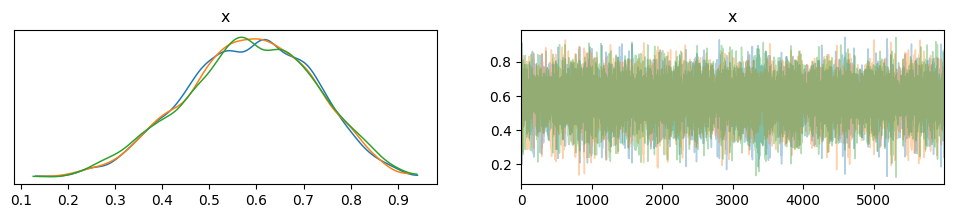

In [28]:
import numpy as np
#trace = format_trace(states,var_name=["p"],chain_dim=1)
display(az.summary(np.array(states)))
az.plot_trace(np.array(states))